In [3]:
!pip install -q transformers
!pip install -q datasets jiwer

In [2]:
#!pip install -q pillow

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Save data path and labels

In [ ]:
import pandas
import os
import csv
from tqdm import tqdm


In [ ]:
#base_path = '/content/drive/MyDrive/Handwritten_health_records'
base_path = '/content/drive/MyDrive/OCR_project/Handwritten_health_records'
iam_data_path = os.path.join(base_path, 'data')
aug_data_path = os.path.join(base_path, 'aug_data')
custom_data_path = os.path.join(base_path, 'custom_data')
#iam_data_label_path = iam_data_path + 'lines.txt'
#aug_data_label_path = aug_data_path + 'line_new.txt'
#custom_data_label_path1 = custom_data_path + 'annot.csv'
#custom_data_label_path2 = custom_data_path + 'annot1.csv'
iam_data_img_path = os.path.join(iam_data_path, 'lines')
aug_data_img_path = os.path.join(aug_data_path, 'aug_lines')
custom_data_img_path = os.path.join(custom_data_path, 'images')
print(iam_data_img_path)

/content/drive/MyDrive/OCR_project/Handwritten_health_records/data/lines


In [ ]:
#a01-000u-00 ok 154 19 408 746 1661 89 A|MOVE|to|stop|Mr.|Gaitskell|from
#part1-part2-part3  : part1/part1-part2/part1-part2-part3

def get_img_path_label(label_path, img_path, file_name):  #iam_data_path, iam_data_img_path
  path_list = []
  label_list = []
  with open(label_path + file_name) as labels:
    for label in tqdm(labels):
      if label[0] == '#':
        continue
      if label.split()[1] == 'err':
        continue
      label = label.strip()
      label = label.split()
      path = label[0].split('-')
      part1 = path[0]
      part2 = path[1]
      path = os.path.join(img_path, part1, part1 + '-' + part2, label[0] + '.png')
      if os.path.getsize(path):
        path_list.append(path)
      else:
        continue
      txt = label[-1].split('|')
      txt = " ".join(txt)
      label_list.append(txt)
  print('Completed')
  return path_list, label_list

In [ ]:
#iam_aug_0.png x x x x x x x x A|MOVE|to|stop|Mr.|Gaitskell|from

def get_img_path_label_(label_path, img_path, file_name):  #iam_data_path, iam_data_img_path
  path_list = []
  label_list = []
  with open(label_path + file_name) as labels:
    for label in tqdm(labels):
      if label[0] == '#':
        continue
      label = label.strip()
      label = label.split()
      path = label[0]
      path = os.path.join(img_path, path)
      path_list.append(path)
      txt = label[-1].split('|')
      txt = " ".join(txt)
      label_list.append(txt)
  print('Completed')
  return path_list, label_list

In [ ]:
iam_data_img_path

'/content/drive/MyDrive/OCR_project/Handwritten_health_records/data/lines'

In [ ]:
path1, label1 = get_img_path_label(iam_data_path, iam_data_img_path, '/lines.txt')
path2, label2 = get_img_path_label_(aug_data_path, aug_data_img_path, '/line_new.txt')
img_paths = path1 + path2
labels = label1 + label2
data = zip(img_paths, labels)
#data_path = '/content/drive/MyDrive/Medical_ocr/data.csv'
data_path = '/content/drive/MyDrive/OCR_project/data.csv'   #using clg id
with open(data_path, 'w', newline='') as file:
  writer = csv.writer(file)
  writer.writerow(['Path', 'Label'])
  writer.writerows(data)

13353it [05:23, 41.25it/s]


Completed


13353it [00:00, 37649.99it/s]

Completed


In [ ]:
len(labels)

24697

#Prepare Data

In [ ]:
import pandas as pd
import os
import csv
from tqdm import tqdm
#data_path = '/content/drive/MyDrive/Medical_ocr/data.csv'
data_path = '/content/drive/MyDrive/OCR_project/data.csv'  #data path for clg id
df = pd.read_csv(data_path)
df = df.sample(frac=1, random_state=42)  #randomize data
df.head()

FileNotFoundError: ignored

In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2)
# we reset the indices to start from zero
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [ ]:
train_df.head()

,Path,Label
0,/content/drive/MyDrive/OCR_project/Handwritten...,of half words .
1,/content/drive/MyDrive/OCR_project/Handwritten...,Conservative . I am horrified and amazed
2,/content/drive/MyDrive/OCR_project/Handwritten...,rest of the country . A Government report has
3,/content/drive/MyDrive/OCR_project/Handwritten...,More modest premises are provided on the upper...
4,/content/drive/MyDrive/OCR_project/Handwritten...,the little hombre in big overalls . Very soon he


In [ ]:
test_df.head()

,Path,Label
0,/content/drive/MyDrive/OCR_project/Handwritten...,be to see there is no racial discrimination
1,/content/drive/MyDrive/OCR_project/Handwritten...,"Only Mr. Lucas's actions , therefore , arose"
2,/content/drive/MyDrive/OCR_project/Handwritten...,the Duke of Wellington .
3,/content/drive/MyDrive/OCR_project/Handwritten...,of a mother who had failed to realise that a son
4,/content/drive/MyDrive/OCR_project/Handwritten...,Ward 10 .


In [ ]:
import torch
from torch.utils.data import Dataset
from PIL import Image

class Dataset(Dataset):
  def __init__(self, df, processor, max_target_length=128):
    self.df = df
    self.processor = processor
    self.max_target_length = max_target_length

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    # get file name + text
    path = self.df['Path'][idx]
    text = self.df['Label'][idx]
    # prepare image (i.e. resize + normalize)
    image = Image.open(path).convert("RGB")
    pixel_values = self.processor(image, return_tensors="pt").pixel_values
    # add labels (input_ids) by encoding the text
    labels = self.processor.tokenizer(text, padding="max_length", max_length=self.max_target_length).input_ids
    # important: make sure that PAD tokens are ignored by the loss function
    labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]
    encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
    return encoding

In [ ]:
from transformers import TrOCRProcessor
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
train_dataset = Dataset(df=train_df, processor=processor)
test_dataset = Dataset(df=test_df, processor=processor)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [ ]:
print('Train Dataset length:', len(train_dataset))
print('Test Dataset length:', len(test_dataset))

Train Dataset length: 19757
Test Dataset length: 4940


In [ ]:
train_dataset[0]

{'pixel_values': tensor([[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [0.9922, 0.9922, 0.9922,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [0.9686, 0.9686, 0.9686,  ..., 1.0000, 1.0000, 1.0000],
          [0.9686, 0.9686, 0.9686,  ..., 1.0000, 1.0000, 1.0000],
          [0.9686, 0.9686, 0.9686,  ..., 1.0000, 1.0000, 1.0000]],
 
         [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [0.9922, 0.9922, 0.9922,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [0.9686, 0.9686, 0.9686,  ..., 1.0000, 1.0000, 1.0000],
          [0.9686, 0.9686, 0.9686,  ..., 1.0000, 1.0000, 1.0000],
          [0.9686, 0.9686, 0.9686,  ..., 1.0000, 1.0000, 1.0000]],
 
         [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [0.9922, 0.992

In [ ]:
encoding = train_dataset[0]  # have both pixel values and padded labels
for k,v in encoding.items():
  print(k, v.shape)

pixel_values torch.Size([3, 384, 384])
labels torch.Size([128])


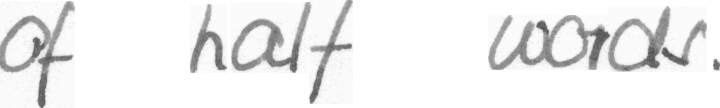

In [ ]:
image = Image.open(train_df['Path'][0]).convert('RGB')
image

In [ ]:
labels = encoding['labels']
print('labels:',labels)
print('-'*100)
labels[labels == -100] = processor.tokenizer.pad_token_id
print('labels:', labels)
print('-'*100)
label_str = processor.decode(labels, skip_special_tokens=True)
print('label_str:', label_str)

labels: tensor([   0, 1116,  457, 1617,  479,    2, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100])
----------------------------------------------------------------------------------------------------
labels: tensor([   0, 1116,  457, 

In [ ]:
from torch.utils.data import DataLoader
batch_size = 8
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

#Train A Model

In [ ]:
from transformers import VisionEncoderDecoderModel
model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-base-stage1')

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-stage1 and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
!pip install transformers[torch]

In [ ]:
!pip install -q accelerate

In [ ]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [ ]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    fp16=True,
    output_dir="/content/drive/MyDrive/Medical_ocr",
    logging_steps=2,
    save_steps=1000,
    eval_steps=200,
)

If you encounter an import error restart the runtime

In [ ]:
from datasets import load_metric
cer_metric = load_metric('cer')

<ipython-input-14-45b51e2d4d00>:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  cer_metric = load_metric('cer')


In [ ]:
def compute_metrics(pred):
  labels_ids = pred.label_ids
  pred_ids = pred.predictions
  pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
  labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
  label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)
  cer = cer_metric.compute(predictions=pred_str, reference=label_str)
  return {'cer': cer}

In [ ]:
from transformers import default_data_collator

# instantiate trainer
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.feature_extractor,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=default_data_collator,
)
trainer.train()
print('Done.')

/usr/local/lib/python3.10/dist-packages/transformers/models/trocr/processing_trocr.py:135: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1270: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation )
  warnings.warn(


TypeError: ignored

#Train the Model

In [ ]:
#loading a checkpoint saved earlier


In [ ]:
from transformers import VisionEncoderDecoderModel
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#loading a checkpoint saved earlier
#model_path = '/content/drive/MyDrive/OCR_project/Medical_ocr/checkpoints/trocr_iam3'  #for clg id
model_path = '/content/drive/MyDrive/Medical_ocr/checkpoints/trocr_iam3'
model = VisionEncoderDecoderModel.from_pretrained(model_path)
#model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-base-stage1')
model.to(device)

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=False)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=False)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fea

In [ ]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

NameError: ignored

In [ ]:
from datasets import load_metric
cer_metric = load_metric('cer')

<ipython-input-29-45b51e2d4d00>:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  cer_metric = load_metric('cer')


In [ ]:
def compute_metrics(pred):
  labels_ids = pred.label_ids
  pred_ids = pred.predictions
  pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
  labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
  label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)
  cer = cer_metric.compute(predictions=pred_str, reference=label_str)
  return cer

In [ ]:
!pip install -q tqdm
from tqdm.notebook import tqdm

In [ ]:
from transformers import AdamW
from tqdm.notebook import tqdm

optimizer = AdamW(model.parameters(), lr=5e-5)
num_epoch = 1  # was 5 earlier 4 already done
version = 1
report_step = 100
model_path = '/content/drive/MyDrive/Medical_ocr/checkpoints'
#model_path = '/content/drive/MyDrive/OCR_project/Medical_ocr/checkpoints'  #for clg id
for epoch in range(num_epoch):
  model.train()
  train_loss = 0.0
  for i, batch in enumerate(tqdm(train_dataloader)):
    for k,v in batch.items():
      batch[k] = v.to(device)

    outputs = model(**batch)
    loss = outputs.loss
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    train_loss += loss.item()
    if i%report_step == 0: print(f'Loss: {loss.item()}')

  print(f'Loss after epoch {epoch+4}:', train_loss/len(train_dataloader))
  model.save_pretrained(os.path.join(model_path, 'trocr_iam'+str(epoch+4)))
model.save_pretrained(os.path.join(model_path, 'trocr_iam'))

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/2470 [00:00<?, ?it/s]

Loss: 1.1818480491638184
Loss: 1.0245088338851929
Loss: 0.8543069958686829
Loss: 1.3113946914672852
Loss: 0.9107129573822021
Loss: 0.6899540424346924
Loss: 0.637965977191925
Loss: 0.8095049858093262
Loss: 0.5384976267814636
Loss: 0.5450131893157959
Loss: 0.5251494646072388
Loss: 0.6191667318344116
Loss: 0.5586789846420288
Loss: 0.5910922884941101
Loss: 1.1697098016738892
Loss: 0.5080723166465759
Loss: 1.2139649391174316
Loss: 2.170408248901367
Loss: 3.0201356410980225
Loss: 1.0039005279541016
Loss: 0.5219464302062988
Loss: 1.0490779876708984
Loss: 1.22566556930542
Loss: 0.771092414855957
Loss: 0.8962962627410889
Loss after epoch 4: 0.9660135191461818


#Testing

In [ ]:
from transformers import VisionEncoderDecoderModel
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#loading a checkpoint saved earlier
model_path = '/content/drive/MyDrive/OCR_project/Medical_ocr/checkpoints/trocr_iam'  #for clg id
#model_path = '/content/drive/MyDrive/Medical_ocr/checkpoints/trocr_iam'
model = VisionEncoderDecoderModel.from_pretrained(model_path)
#model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-base-stage1')
model.to(device)

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=False)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=False)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fea

In [ ]:
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=True)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1270: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation )
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1369: UserWarning: Using `max_length`'s default (64) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


True label: Absorption of the beta particles is also kept to a
Pred label: Absapaporption of the beta particles is also to


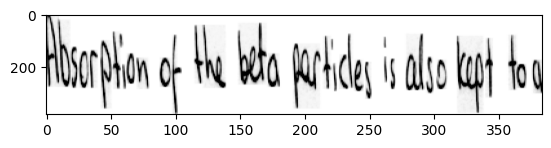

In [ ]:
i = 0
for batch in (test_dataloader):
  #print(batch)
  for k,v in batch.items():
    batch[k] = v.to(device)
  outputs = model.generate(batch['pixel_values'].to(device))
  px = batch['pixel_values'][i].cpu().numpy()
  labels = batch['labels'][i]
  pred = outputs[i]
  break

import matplotlib.pyplot as plt
plt.imshow(px.transpose([1,2,0]), aspect=1/5)
label_pred = processor.decode(pred, skip_special_tokens=True)
label_true = labels
label_true[label_true == -100] = processor.tokenizer.pad_token_id
label_true = processor.decode(label_true, skip_special_tokens=True)
print('True label:', label_true)
print('Pred label:', label_pred)


Evaluate

In [ ]:
def true_label(label_true, processor):
  label_true[label_true == -100] = processor.tokenizer.pad_token_id
  label_true = processor.decode(label_true, skip_special_tokens=True)
  return label_true

In [ ]:
from datasets import load_metric
cer_metric = load_metric('cer')

def compute_metrics(pred_ids, label_ids):
  label_ids[label_ids == -100] = processor.tokenizer.pad_token_id
  label_ids = processor.batch_decode(label_ids, skip_special_tokens=True)
  pred_ids = processor.batch_decode(pred_ids, skip_special_tokens=True)
  #print('')
  #print('label:', label_ids)
  #print('pred:', pred_ids)
  cer = cer_metric.compute(predictions = pred_ids, references=label_ids)
  return cer

<ipython-input-21-bb1ca7fedba8>:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  cer_metric = load_metric('cer')


In [ ]:
pred_ids = ["chapter in the history of Anglesey's second", 'commercial development that the']
label_ids = ["chapter in the history of Anglesey's unceasing search", 'commercial development that the']
cer_metric.compute(predictions = pred_ids, references=label_ids)

0.16666666666666666

In [ ]:
model.eval()
valid_cer = 0.0
with torch.no_grad():
  for i, batch in enumerate(tqdm(test_dataloader)):
    # run batch generation
    outputs = model.generate(batch['pixel_values'].to(device))
    labels = batch['labels']
    cer = compute_metrics(pred_ids=outputs, label_ids=labels)
    valid_cer += cer
print('Validation CER:', valid_cer/len(test_dataloader))

  0%|          | 0/618 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1369: UserWarning: Using `max_length`'s default (64) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
100%|██████████| 618/618 [1:18:40<00:00,  7.64s/it]

Validation CER: 0.14390881212195394


#Calculating CER of iam finetuned trocr

In [ ]:
!pip install -q transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 40.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 77.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 69.4 MB/s eta 0:00:00


In [ ]:
from transformers import TrOCRProcessor
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
train_dataset = Dataset(df=train_df, processor=processor)
test_dataset = Dataset(df=test_df, processor=processor)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
from transformers import VisionEncoderDecoderModel
model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-base-handwritten')
model.to(device)

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=False)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=False)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fea

In [ ]:
device = torch.device('gpu' if torch.cuda.is_available() else 'cpu')
model.to(device)

In [ ]:
from torch.utils.data import DataLoader
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=True)

In [ ]:
from datasets import load_metric
cer_metric = load_metric('cer')

def compute_metrics(pred_ids, label_ids):
  label_ids[label_ids == -100] = processor.tokenizer.pad_token_id
  label_ids = processor.batch_decode(label_ids, skip_special_tokens=True)
  pred_ids = processor.batch_decode(pred_ids, skip_special_tokens=True)
  cer = cer_metric.compute(predictions = pred_ids, references=label_ids)
  return cer

<ipython-input-19-1d6e42c22d44>:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  cer_metric = load_metric('cer')


In [ ]:
model.eval()
valid_cer = 0.0
with torch.no_grad():
  for i, batch in enumerate(tqdm(test_dataloader)):
    # run batch generation
    outputs = model.generate(batch['pixel_values'].to(device))
    labels = batch['labels']
    cer = compute_metrics(pred_ids=outputs, label_ids=labels)
    valid_cer += cer
print('Validation CER:', valid_cer/len(test_dataloader))

  0%|          | 0/618 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1369: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
100%|██████████| 618/618 [1:24:03<00:00,  8.16s/it]

Validation CER: 0.03669553495275376


#Checking custom Dataset

In [4]:
import os
import csv
data_path = '/content/drive/MyDrive/Handwritten_health_records/custom_data'

In [33]:
import pandas as pd
df1 = pd.read_csv(os.path.join(data_path, 'annot.csv'))
df2 = pd.read_csv(os.path.join(data_path, 'annot1.csv'))

In [34]:
df1.head()

,images,label
0,64-1.png,Bilazo
1,64-2.png,Tb Livisiz -m
2,64-3.png,histoglob s/c 1sht
3,65-1.png,Bilazo 20mg
4,65-2.png,Levosiz-M SOS


In [35]:
df2.head()

,images,label
0,cust_aug_0_0.png,Bilazo
1,cust_aug_0_1.png,Bilazo
2,cust_aug_0_2.png,Bilazo
3,cust_aug_0_3.png,Bilazo
4,cust_aug_1_0.png,Tb Livisiz -m


In [36]:
data = pd.concat([df1, df2])
data.head()

,images,label
0,64-1.png,Bilazo
1,64-2.png,Tb Livisiz -m
2,64-3.png,histoglob s/c 1sht
3,65-1.png,Bilazo 20mg
4,65-2.png,Levosiz-M SOS


In [37]:
len(data)

765

In [38]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(data, test_size=0.2)
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [42]:
train_df.head()

,images,label
0,cust_aug_145_2.png,DOLO 650
1,cust_aug_111_1.png,Syr Zifi
2,cust_aug_45_1.png,Tab Folic acid
3,cust_aug_77_2.png,T. Cal. 500mg od
4,cust_aug_148_1.png,Tab OND 10


In [43]:
test_df.head()

,images,label
0,cust_aug_58_3.png,Steam before sleep X 4 day
1,cust_aug_38_1.png,No B symptoms
2,cust_aug_62_2.png,Tab Metrogyl 400
3,cust_aug_1_2.png,Tb Livisiz -m
4,cust_aug_112_3.png,Syr. Meftal P 5ml-


In [44]:
import torch
from torch.utils.data import Dataset
from PIL import Image
img_path = '/content/drive/MyDrive/Handwritten_health_records/custom_data/images'


class Dataset(Dataset):
  def __init__(self, df, processor, img_path, max_target_length=128):
    self.df = df
    self.processor = processor
    self.max_target_length = max_target_length
    self.img_path = img_path

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    name = self.df['images'][idx]
    text = self.df['label'][idx]
    image = Image.open(os.path.join(self.img_path, name)).convert('RGB')
    pixel_values = self.processor(image, return_tensors='pt').pixel_values
    labels = self.processor.tokenizer(text, padding='max_length', max_length=self.max_target_length).input_ids
    labels = [label if label !=self.processor.tokenizer.pad_token_id else -100 for label in labels]
    encoding = {'pixel_values': pixel_values.squeeze(), 'labels': torch.tensor(labels)}
    return encoding

In [45]:
from transformers import TrOCRProcessor
processor = TrOCRProcessor.from_pretrained('microsoft/trocr-base-handwritten')
train_dataset = Dataset(df=train_df,processor=processor, img_path=img_path)
test_dataset = Dataset(df=test_df, processor=processor, img_path=img_path)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [46]:
print('Train Dataset length:', len(train_dataset))
print('Test Dataset length:', len(test_dataset))

Train Dataset length: 612
Test Dataset length: 153


In [47]:
encoding = train_dataset[0]
encoding

{'pixel_values': tensor([[[0.6392, 0.6392, 0.6314,  ..., 0.6627, 0.6627, 0.6627],
          [0.6392, 0.6392, 0.6314,  ..., 0.6627, 0.6627, 0.6627],
          [0.6392, 0.6392, 0.6314,  ..., 0.6627, 0.6627, 0.6627],
          ...,
          [0.0980, 0.0980, 0.0980,  ..., 0.0980, 0.0980, 0.0980],
          [0.0980, 0.0980, 0.0980,  ..., 0.0980, 0.0980, 0.0980],
          [0.0980, 0.0980, 0.0980,  ..., 0.0980, 0.0980, 0.0980]],
 
         [[0.6000, 0.6000, 0.5922,  ..., 0.6235, 0.6235, 0.6235],
          [0.6000, 0.6000, 0.5922,  ..., 0.6235, 0.6235, 0.6235],
          [0.6000, 0.6000, 0.5922,  ..., 0.6235, 0.6235, 0.6235],
          ...,
          [0.0745, 0.0745, 0.0745,  ..., 0.0824, 0.0824, 0.0824],
          [0.0745, 0.0745, 0.0745,  ..., 0.0824, 0.0824, 0.0824],
          [0.0745, 0.0745, 0.0745,  ..., 0.0824, 0.0824, 0.0824]],
 
         [[0.5686, 0.5686, 0.5608,  ..., 0.5922, 0.5922, 0.5922],
          [0.5686, 0.5686, 0.5608,  ..., 0.5922, 0.5922, 0.5922],
          [0.5686, 0.568

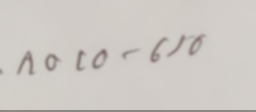

In [48]:
image = Image.open(os.path.join(img_path, train_df['images'][0])).convert('RGB')
image

In [49]:
labels = encoding['labels']
print('labels:', labels)
print('-'*100)
labels[labels==-100] = processor.tokenizer.pad_token_id
print('labels:', labels)
print('-'*100)
label_str = processor.decode(labels, skip_special_tokens=True)
print('label_str:', label_str)

labels: tensor([    0,   495,  3384,   673, 17594,     2,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         -100,  -100,  -100,  -100,  -100,  -100,  -100,

In [50]:
from torch.utils.data import DataLoader
batch_size = 8
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [51]:
!pip install -q transformers

In [52]:
import torch

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1369: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


True label: two times
Pred label: tuxoting
True label: Tab Zathrin (250mg)
Pred label: MRB. Zatigism,
True label: pysiotherapy
Pred label: transparency.
True label: Bilazo 20 mg
Pred label: otherness


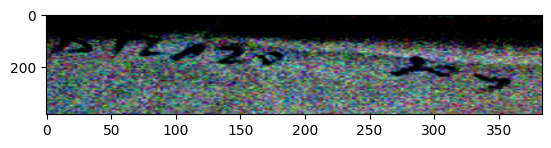

In [32]:
i = 4
px = []
labels = []
pred = []
for batch in (train_dataloader):
  #print(batch)
  for k,v in batch.items():
    batch[k] = v.to(device)
  outputs = model.generate(batch['pixel_values'].to(device))
  for j in range(i):
    px.append(batch['pixel_values'][j].cpu().numpy())
    labels.append(batch['labels'][j])
    pred.append(outputs[j])
  break

import matplotlib.pyplot as plt
for k in range(i):
  plt.imshow(px[k].transpose([1,2,0]), aspect=1/5)
  label_pred = processor.decode(pred[k], skip_special_tokens=True)
  label_true = labels[k]
  label_true[label_true == -100] = processor.tokenizer.pad_token_id
  label_true = processor.decode(label_true, skip_special_tokens=True)
  print('True label:', label_true)
  print('Pred label:', label_pred)

  #lol the predictions are shit

save train and test dataset saperately as we are going to train the model in steps, so to make sure train and test doest get mixed you need to do this

In [41]:
data_path = '/content/drive/MyDrive/Medical_ocr'
train_df.to_csv(os.path.join(data_path,'custom_train.csv'), index=False)
test_df.to_csv(os.path.join(data_path,'custom_test.csv'), index=False)

#Fine-tune on custom dataset

In [5]:
import os
import pandas as pd
data_path = '/content/drive/MyDrive/Medical_ocr'
train_df = pd.read_csv(os.path.join(data_path, 'custom_train.csv'))
test_df = pd.read_csv(os.path.join(data_path, 'custom_test.csv'))

In [7]:
train_df.head()

,images,label
0,cust_aug_145_2.png,DOLO 650
1,cust_aug_111_1.png,Syr Zifi
2,cust_aug_45_1.png,Tab Folic acid
3,cust_aug_77_2.png,T. Cal. 500mg od
4,cust_aug_148_1.png,Tab OND 10


In [8]:
import torch
from torch.utils.data import Dataset
from PIL import Image
img_path = '/content/drive/MyDrive/Handwritten_health_records/custom_data/images'


class Dataset(Dataset):
  def __init__(self, df, processor, img_path, max_target_length=128):
    self.df = df
    self.processor = processor
    self.max_target_length = max_target_length
    self.img_path = img_path

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    name = self.df['images'][idx]
    text = self.df['label'][idx]
    image = Image.open(os.path.join(self.img_path, name)).convert('RGB')
    pixel_values = self.processor(image, return_tensors='pt').pixel_values
    labels = self.processor.tokenizer(text, padding='max_length', max_length=self.max_target_length).input_ids
    labels = [label if label !=self.processor.tokenizer.pad_token_id else -100 for label in labels]
    encoding = {'pixel_values': pixel_values.squeeze(), 'labels': torch.tensor(labels)}
    return encoding

In [9]:
from transformers import TrOCRProcessor
processor = TrOCRProcessor.from_pretrained('microsoft/trocr-base-handwritten')
train_dataset = Dataset(df=train_df,processor=processor, img_path=img_path)
test_dataset = Dataset(df=test_df, processor=processor, img_path=img_path)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [10]:
print('Train dataset length:', len(train_dataset))
print('Test dataset length:', len(test_dataset))

Train dataset length: 612
Test dataset length: 153


In [11]:
train_dataset[0]

{'pixel_values': tensor([[[0.6392, 0.6392, 0.6314,  ..., 0.6627, 0.6627, 0.6627],
          [0.6392, 0.6392, 0.6314,  ..., 0.6627, 0.6627, 0.6627],
          [0.6392, 0.6392, 0.6314,  ..., 0.6627, 0.6627, 0.6627],
          ...,
          [0.0980, 0.0980, 0.0980,  ..., 0.0980, 0.0980, 0.0980],
          [0.0980, 0.0980, 0.0980,  ..., 0.0980, 0.0980, 0.0980],
          [0.0980, 0.0980, 0.0980,  ..., 0.0980, 0.0980, 0.0980]],
 
         [[0.6000, 0.6000, 0.5922,  ..., 0.6235, 0.6235, 0.6235],
          [0.6000, 0.6000, 0.5922,  ..., 0.6235, 0.6235, 0.6235],
          [0.6000, 0.6000, 0.5922,  ..., 0.6235, 0.6235, 0.6235],
          ...,
          [0.0745, 0.0745, 0.0745,  ..., 0.0824, 0.0824, 0.0824],
          [0.0745, 0.0745, 0.0745,  ..., 0.0824, 0.0824, 0.0824],
          [0.0745, 0.0745, 0.0745,  ..., 0.0824, 0.0824, 0.0824]],
 
         [[0.5686, 0.5686, 0.5608,  ..., 0.5922, 0.5922, 0.5922],
          [0.5686, 0.5686, 0.5608,  ..., 0.5922, 0.5922, 0.5922],
          [0.5686, 0.568

In [12]:
from torch.utils.data import DataLoader
batch_size = 8
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [13]:
!pip install -q tqdm
from tqdm.notebook import tqdm

In [14]:
from transformers import VisionEncoderDecoderModel
model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-base-handwritten')
model_path = '/content/drive/MyDrive/Medical_ocr/checkpoints'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=False)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=False)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fea

In [15]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [16]:
from datasets import load_metric
cer_metric = load_metric('cer')

<ipython-input-16-45b51e2d4d00>:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  cer_metric = load_metric('cer')


In [17]:
def compute_metrics(pred):
  labels_ids = pred.label_ids
  pred_ids = pred.predictions
  pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
  labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
  label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)
  cer = cer_metric.compute(predictions=pred_str, reference=label_str)
  return cer

In [19]:
from transformers import AdamW
from tqdm.notebook import tqdm

optimizer = AdamW(model.parameters(), lr=5e-5)
num_epoch = 5
report_step = 10
model_path = '/content/drive/MyDrive/Medical_ocr/checkpoints'
#model_path = '/content/drive/MyDrive/OCR_project/Medical_ocr/checkpoints'  #for clg id
for epoch in range(num_epoch):
  model.train()
  train_loss = 0.0
  for i, batch in enumerate(tqdm(train_dataloader)):
    for k,v in batch.items():
      batch[k] = v.to(device)

    outputs = model(**batch)
    loss = outputs.loss
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    train_loss += loss.item()
    if i%report_step == 0: print(f'Loss: {loss.item()}')

  print(f'Loss after epoch {epoch}:', train_loss/len(train_dataloader))
  model.save_pretrained(os.path.join(model_path, 'custom_trocr_iam'+str(epoch)))
model.save_pretrained(os.path.join(model_path, 'custom_trocr_iam'))

  0%|          | 0/77 [00:00<?, ?it/s]

Loss: 4.488770008087158
Loss: 3.189052104949951
Loss: 1.7370717525482178
Loss: 0.9394094944000244
Loss: 2.0018930435180664
Loss: 1.0708690881729126
Loss: 0.6544707417488098
Loss: 1.137800693511963
Loss after epoch 0: 1.9010262319019862


  0%|          | 0/77 [00:00<?, ?it/s]

Loss: 0.13151107728481293
Loss: 0.27839982509613037
Loss: 0.4086245000362396
Loss: 0.09467082470655441
Loss: 0.29620516300201416
Loss: 0.16989721357822418
Loss: 0.2817498445510864
Loss: 0.3214956521987915
Loss after epoch 1: 0.2915327910382252


  0%|          | 0/77 [00:00<?, ?it/s]

Loss: 0.18991133570671082
Loss: 0.04949944466352463
Loss: 0.1808338761329651
Loss: 0.4522192180156708
Loss: 0.6833270192146301
Loss: 0.04160924255847931
Loss: 0.4603271186351776
Loss: 0.06749044358730316
Loss after epoch 2: 0.20899677834195363


  0%|          | 0/77 [00:00<?, ?it/s]

Loss: 0.015539686195552349
Loss: 0.0915878415107727
Loss: 0.03490633890032768
Loss: 0.0357353501021862
Loss: 0.023615853860974312
Loss: 0.03945643827319145
Loss: 0.1585048884153366
Loss: 0.009640295058488846
Loss after epoch 3: 0.12114751361334672


  0%|          | 0/77 [00:00<?, ?it/s]

Loss: 0.02482839673757553
Loss: 0.10977707803249359
Loss: 0.017039921134710312
Loss: 0.0831599310040474
Loss: 0.0051625450141727924
Loss: 0.022992974147200584
Loss: 0.014859049580991268
Loss: 0.011315971612930298
Loss after epoch 4: 0.06338156581033844


In [20]:
from transformers import VisionEncoderDecoderModel
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#loading a checkpoint saved earlier
#model_path = '/content/drive/MyDrive/OCR_project/Medical_ocr/checkpoints/custom_troct_iam'  #for clg id
model_path = '/content/drive/MyDrive/Medical_ocr/checkpoints/custom_trocr_iam'
model = VisionEncoderDecoderModel.from_pretrained(model_path)
#model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-base-stage1')
model.to(device)

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=False)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=False)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fea

In [22]:
from datasets import load_metric
cer_metric = load_metric('cer')

def compute_metrics(pred_ids, label_ids):
  label_ids[label_ids == -100] = processor.tokenizer.pad_token_id
  label_ids = processor.batch_decode(label_ids, skip_special_tokens=True)
  pred_ids = processor.batch_decode(pred_ids, skip_special_tokens=True)
  cer = cer_metric.compute(predictions = pred_ids, references=label_ids)
  return cer

In [23]:
model.eval()
valid_cer = 0.0
with torch.no_grad():
  for i, batch in enumerate(tqdm(test_dataloader)):
    # run batch generation
    outputs = model.generate(batch['pixel_values'].to(device))
    labels = batch['labels']
    cer = compute_metrics(pred_ids=outputs, label_ids=labels)
    valid_cer += cer
print('Validation CER:', valid_cer/len(test_dataloader))

  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1369: UserWarning: Using `max_length`'s default (64) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Validation CER: 0.03937574789571886


True label: Homide Eye drop
Pred label: Homide Eye drop
True label: IPF -> 28%
Pred label: IPF -> 28%
True label: Cap Rinifol
Pred label: Cap Rinifol
True label: Syr Tuspel Plus
Pred label: Syr Tuspel Plus
True label: odipraz 40
Pred label: odipraz 40
True label: two times
Pred label: two times
True label: Tab Duciclav 625
Pred label: Tab Duciclav 625
True label: SPO2=93  pulse =102  Temp=36.5
Pred label: SPO2=93  pulse =102  Temp=36.5


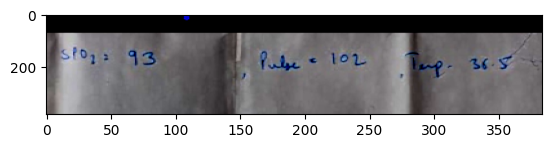

In [25]:
i = 8
px = []
labels = []
pred = []

for batch in (train_dataloader):
  #print(batch)
  for k,v in batch.items():
    batch[k] = v.to(device)
  outputs = model.generate(batch['pixel_values'].to(device))
  for j in range(i):
    px.append(batch['pixel_values'][j].cpu().numpy())
    labels.append(batch['labels'][j])
    pred.append(outputs[j])
  break

import matplotlib.pyplot as plt
for k in range(i):
  plt.imshow(px[k].transpose([1,2,0]), aspect=1/5)
  label_pred = processor.decode(pred[k], skip_special_tokens=True)
  label_true = labels[k]
  label_true[label_true == -100] = processor.tokenizer.pad_token_id
  label_true = processor.decode(label_true, skip_special_tokens=True)
  print('True label:', label_true)
  print('Pred label:', label_pred)

  #lol the predictions are shit